<a href="https://colab.research.google.com/github/johntaraj/Katy-Perry-or-Zooey-Deschanel-detector/blob/main/KatyPerryorZooeyDeschanel_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -U duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 1.6 MB/s eta 0:00:00


In [2]:
from duckduckgo_search import DDGS
from fastcore.all import *

ddgs = DDGS()

def search_images(term, max_images=200):
  print(f"Searchin for '{term}' ")
  return L(ddgs.images(term, max_results=max_images)).itemgot('image')


In [3]:

urls = search_images('Katy Perry', max_images=1)
urls[0]


Searchin for 'Katy Perry' 


'https://fanfap.com/wp-content/uploads/bpvi1wb5ktr51.jpg'

## downloading the photo that we search

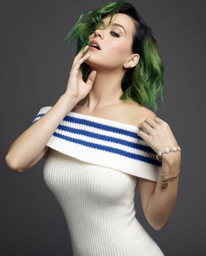

In [4]:
from fastdownload import download_url

dest='katy.jpg'

download_url(urls[0], dest, show_progress=True)

from fastai.vision.all import* #fastai library to do photo manipulations

im= Image.open(dest)
im.to_thumb(256,256)

Searchin for 'Zooey Deschanel' 


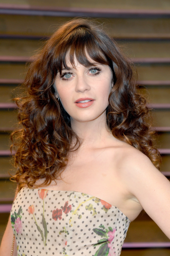

In [5]:
#downloading now a photo of Zooey

download_url(search_images('Zooey Deschanel',max_images=1)[0], 'zooey.jpg', show_progress=True)
Image.open('zooey.jpg').to_thumb(256,256)

## Creating a dataset from DDG images

In [6]:
searches = 'Katy Perry', 'Zooey Deschanel'
path = Path('dataSet')

from time import sleep

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True )
  download_images(dest, urls =search_images(f'{o} with glasses'))
  sleep(10)
  download_images(dest, urls =search_images(f'{o} in 2010s'))
  sleep(10)
  download_images(dest, urls =search_images(f'{o} outfits'))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

Searchin for 'Katy Perry with glasses' 
Searchin for 'Katy Perry in 2010s' 
Searchin for 'Katy Perry outfits' 
Searchin for 'Zooey Deschanel with glasses' 
Searchin for 'Zooey Deschanel in 2010s' 
Searchin for 'Zooey Deschanel outfits' 


In [7]:
failed = verify_images(get_image_files(path)) #path here can also not be written, because the functio  get_image_files searches itself for all the images, in any subfolder of the main folder
failed.map(Path.unlink) #remove the failed photos from our repo
len(failed)

35

# Using the data to train and test the model

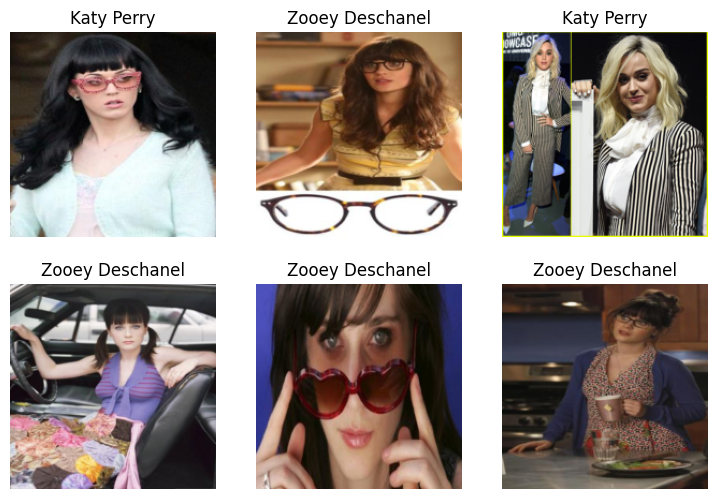

In [8]:
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct= 0.2, seed=42),
    get_y = parent_label,
    item_tfms = [Resize(192,method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [9]:
#finetuning an already famous vision model(resnet18)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3) #brings an okayish error rate of 6% good enough for some random data from the internet

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 104MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.830424,0.548772,0.207447,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.396766,0.523287,0.164894,00:04
1,0.222304,0.442109,0.132979,00:05
2,0.143853,0.414468,0.127660,00:04


## MOMENT OF TRUTH!
### Lets try our model and see if it recognize Katy Perry

In [10]:
is_katy,_, probs = learn.predict(PILImage.create('zooey.jpg'))
print(f'This is a : {is_katy}')
print(f'Probability it is Katy Perry is :{probs[0]:.4f}')

This is a : Zooey Deschanel
Probability it is Katy Perry is :0.0005


In [11]:
learn.export('model.pkl')